In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 1226, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 1226 (delta 102), reused 83 (delta 58), pack-reused 1077 (from 1)
Receiving objects: 100% (1226/1226), 31.14 MiB | 20.27 MiB/s, done.
Resolving deltas: 100% (759/759), done.
Filtering content: 100% (33/33), 1.75 GiB | 135.04 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install numpy==1.26.3 # necessary for bug fix
!pip install peft==0.10.0
!pip install pykalman
!pip install ta
!pip install scikit-optimize

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
!pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0

  Using cached peft-0.10.0-py3-none-any.whl.metadata (13 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux

In [3]:
# bunch of the initialization code #

### RESULTS IMPORTS ###
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any, Sequence
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime
from transformers import AutoModelForCausalLM, AutoConfig
from torch.utils.data import DataLoader, TensorDataset

# Custom Imports
from models.statistical_models import kalman_filter_average, kalman_filter_regression
from models.transformer_model import TimeSeriesTransformerv1, get_cosine_schedule_with_warmup_and_min_lr
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison
from utils.helpers import _get_train_dev_frac
from external.time_moe_repo.training_wrapper import train_time_moe
from backtesting.trading_strategy import get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty

## semi-custom
from external.time_moe_repo.time_moe.models.modeling_time_moe import TimeMoeForPrediction

# important for time moe
import wandb
wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(trade)) # in this case, check whether the new trade function  is imported
### RESULTS IMPORTS ###


### HYPERPARAM OPTIMIZATION IMPORTS ###
## data gathering imports
from utils.helpers import _get_train_dev_frac
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, gather_data_cached_using_truncate, gather_pairs_data_cached, save_pairs_data_filtered

## workflow imports
from models.statistical_models import execute_kalman_workflow

## optimize-specific imports
from skopt import gp_minimize
from skopt import plots as skplots
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
import numpy as np
from typing import Callable, Any, List, Dict, Tuple
import time
import random
from sklearn.metrics import mean_squared_error
from functools import partial


from utils.helpers import return_score
from utils.visualization import results_to_latex
from utils.optimization import bayesian_optimize_workflow
### HYPERPARAM OPTIMIZATION IMPORTS ###

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: davidmoerdijk (davidmoerdijk-smart-backoffice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# 2. Results

In [15]:
### Unchanged variables ###
verbose = True
return_datasets = True
### Unchanged variables ###

## Kalman Filter

In [30]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = {'delta': 0.014784091621725818, 'obs_cov_reg': 2.5600560664086465, 'trans_cov_avg': 0.09999999999999999, 'obs_cov_avg': 3.4796803986835676}

### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2020
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

wanted_pair = pairs_data_filtered[9][0]
ticker_a, ticker_b = wanted_pair[0], wanted_pair[1]
# should be ('10. (IFGL,EMB)', 0.00461, 0.4754, 0.80221, '1.58% +- 0.25%', '0.53%', 1.01)
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###

def execute_kalman_workflow(
  pairs_timeseries: pd.DataFrame,
  target_col: str = "Spread_Close",
  col_s1: str = "S1_close",
  col_s2: str = "S2_close",
  train_frac: float = 0.90,
  dev_frac: float = 0.05,
  seed: int = 3178749, # for reproducibility, my student number
  look_back: int = 1,
  yearly_trading_days: int = 252,
  ## optimized hyperparams ##
  delta: float = 1e-3,
  obs_cov_reg: float = 2.,
  trans_cov_avg: float = 0.01,
  obs_cov_avg: float = 1.,
  ## optimized hyperparams ##
  return_datasets: bool = False,
  verbose: bool = True,
  result_parent_dir: str = "data/results",
  filename_base: str = "data_begindate_enddate_hash.pkl", # use `_get_filename(startDateStr, endDateStr, instrumentIds)`
  pair_tup_str: str = "(?,?)", # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
):
  # Set seeds
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  # For GPU (if used)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism

  # Check whether everything is present as expected (good practice, and gives useful exceptions)
  required = {col_s1, col_s2}
  if not required.issubset(pairs_timeseries.columns):
      raise KeyError(f"pairs_timeseries must contain {required}")

  total_len = len(pairs_timeseries)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train_univariate = pairs_timeseries.iloc[:train_size][target_col]
  dev_univariate = pairs_timeseries.iloc[train_size:train_size + dev_size][target_col]
  test_univariate = pairs_timeseries.iloc[train_size + dev_size:][target_col]

  train_multivariate = pairs_timeseries.iloc[:train_size]
  dev_multivariate = pairs_timeseries.iloc[train_size:train_size + dev_size]
  test_multivariate = pairs_timeseries.iloc[train_size + dev_size:]

  if verbose:
      print(f"Split sizes — train: {len(train_univariate)}, dev: {len(dev_univariate)}, test: {len(test_univariate)}")

  beta_t_train = - kalman_filter_regression(
      kalman_filter_average(train_multivariate[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(train_multivariate[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_train_raw = train_multivariate[col_s1] + train_multivariate[col_s2] * beta_t_train # merely used for scaling dev without lookahead bias

  # get dev forecasts
  beta_t_dev = - kalman_filter_regression(
      kalman_filter_average(dev_multivariate[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(dev_multivariate[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_dev_raw = dev_multivariate[col_s1] + dev_multivariate[col_s2] * beta_t_dev
  forecast_dev = (forecast_dev_raw - forecast_train_raw.mean()) / forecast_train_raw.std()

  # get test forecasts
  beta_t_test = - kalman_filter_regression(
      kalman_filter_average(test_multivariate[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(test_multivariate[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_test_raw = test_multivariate[col_s1] + test_multivariate[col_s2] * beta_t_test
  forecast_test = (forecast_test_raw - forecast_dev_raw.mean()) / forecast_dev_raw.std()

  beta_t_full = - kalman_filter_regression(
      kalman_filter_average(pairs_timeseries[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(pairs_timeseries[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_full_raw = pairs_timeseries[col_s1] + pairs_timeseries[col_s2] * beta_t_full
  forecast_full = (forecast_full_raw - forecast_full_raw.mean()) / forecast_full_raw.std()

  if look_back == 1:
      # Calculate mse values
      test_mse = mean_squared_error(test_univariate, forecast_test)
      test_var = np.var(test_univariate)
      test_nmse = test_mse / test_var if test_var != 0 else 0.0

      # also for validation
      val_mse = mean_squared_error(dev_univariate, forecast_dev)
      val_var = np.var(dev_univariate)
      val_nmse = val_mse / val_var if val_var != 0 else 0.
  else:
      raise NotImplementedError("Warning: look_back > 1 not yet implemented. Returning None for mse.")

  ### TRADING ###
  # calculate std_dev_pct using the logic from plot_with_uncertainty. Then put that into two separate functions: calculate_yoy_uncertainty and a version of plot_with_uncertainty that uses calculate_yoy_uncertainty
  # position threshold (2.00-4.00), clearing threshold (0.30-0.70)
  min_position = 2.00
  max_position = 4.00
  min_clearing = 0.30
  max_clearing = 0.70
  position_thresholds = np.linspace(min_position, max_position, num=10)
  clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)

  test_s1 = test_multivariate['S1_close']
  test_s2 = test_multivariate['S2_close']

  yoy_mean, yoy_std = calculate_return_uncertainty(test_s1, test_s2, forecast_test, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)
  # calculate the strategy returns if we were to feed the groundtruth values to the `trade` func. If the ground truth returns are lower, it seems likely there is something wrong with the `trade` func (but not certain! Probability applies here).
  output = get_gt_yoy_returns_test_dev(pairs_timeseries, dev_frac, train_frac, look_back=0, yearly_trading_days=yearly_trading_days)
  gt_yoy, gt_yoy_for_dev_dataset = output['gt_yoy_test'], output['gt_yoy_dev']

  current_result_dir = filename_base.replace(".pkl", "_kalman")
  result_dir = os.path.join(result_parent_dir, current_result_dir)
  if not os.path.exists(result_dir):
      os.makedirs(result_dir)

  output: Dict[str, Any] = dict(
      val_mse=val_nmse,
      test_mse=test_nmse,
      yoy_mean=yoy_mean,
      yoy_std=yoy_std,
      gt_yoy=gt_yoy,
      result_parent_dir=result_parent_dir,
  )

  results_str = f"""
Validation MSE: {output['val_mse']}
Test MSE: {output['test_mse']}
YOY Returns: {output['yoy_mean'] * 100:.2f}%
YOY Std: +- {output['yoy_std'] * 100:.2f}%
GT Yoy: {output['gt_yoy'] * 100:.2f}%
Plot filepath parent dir: {output['result_parent_dir']}
pair_tup_str: {pair_tup_str}
  """
  with open(os.path.join(result_dir, "results.txt"), "w") as f:
      f.write(results_str)
  if verbose:
    print(results_str)
  if return_datasets:
      output.update(
          dict(
            pairs_timeseries=pairs_timeseries,
            test_s1_shortened=test_s1,
            test_s2_shortened=test_s2,
            forecast_train=(forecast_train_raw - forecast_train_raw.mean()) / forecast_train_raw.std(),
            forecast_dev=forecast_dev,
            forecast_old_method=forecast_full, # has lookahead bias
            forecast_test_shortened_series=forecast_test,
            gt_test_shortened_series=test_univariate
          )
      )
  return output

### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2022
pair_tup_str_current = f"({ticker_a},{ticker_b})"
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
output_kalman = execute_kalman_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
# print(output_model
yoy_str = f"{output_kalman['yoy_mean'] * 100:.2f}% +- {output_kalman['yoy_std'] * 100:.2f}%"
returns_score = return_score(output_kalman['yoy_mean'], gt_yoy)

Split sizes — train: 2769, dev: 251, test: 253

Validation MSE: 0.47540072481808193
Test MSE: 0.8022096756866918
YOY Returns: 1.58%
YOY Std: +- 0.25%
GT Yoy: 0.61%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  


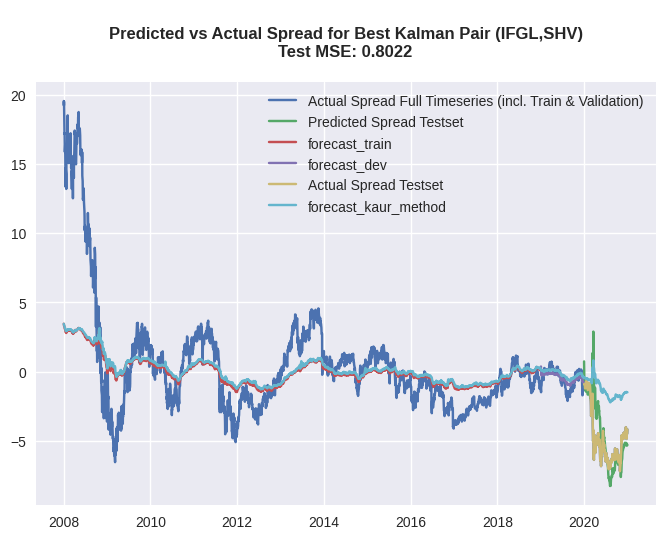

In [31]:
title = f"""
Predicted vs Actual Spread for Best Kalman Pair (IFGL,SHV)
Test MSE: {output_kalman['test_mse']:.4f}
"""

def _KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)

  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression
def _KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means
pairs_timeseries = output_kalman['pairs_timeseries']
state_means = - _KalmanFilterRegression(_KalmanFilterAverage(pairs_timeseries.S1_close),_KalmanFilterAverage(pairs_timeseries.S2_close))[:,0]

results = pairs_timeseries.S1_close + (pairs_timeseries.S2_close * state_means)
forecast_kaur_method = (results - results.mean()) / results.std()



plt.title(title, fontweight='bold')
plt.plot(output_kalman['pairs_timeseries']['Spread_Close'], label="Actual Spread Full Timeseries (incl. Train & Validation)")
plt.plot(output_kalman['forecast_test_shortened_series'], label="Predicted Spread Testset")
plt.plot(output_kalman['forecast_train'], label="forecast_train")
plt.plot(output_kalman['forecast_dev'], label="forecast_dev")
plt.plot(output_kalman['gt_test_shortened_series'], label="Actual Spread Testset")
plt.plot(forecast_kaur_method, label="forecast_kaur_method")
plt.legend()
plt.show()

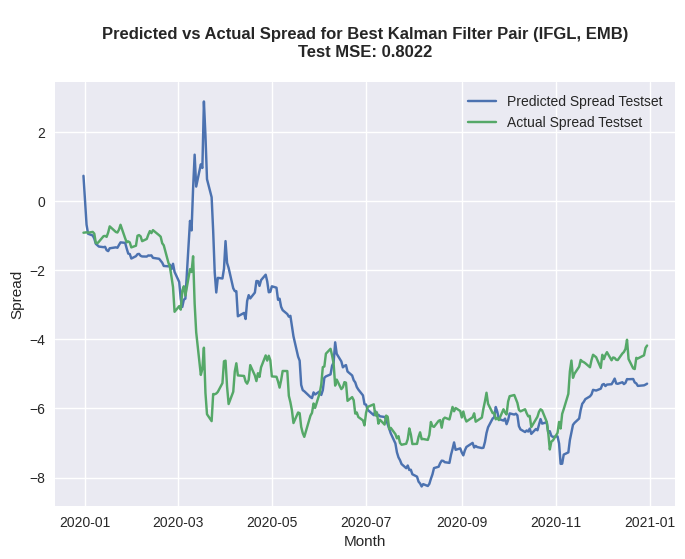

In [32]:
title = f"""
Predicted vs Actual Spread for Best Kalman Filter Pair (IFGL, EMB)
Test MSE: {output_kalman['test_mse']:.4f}
"""

plt.title(title, fontweight='bold')
plt.plot(output_kalman['forecast_test_shortened_series'], label="Predicted Spread Testset")
plt.plot(output_kalman['gt_test_shortened_series'], label="Actual Spread Testset")
plt.xlabel("Month")
plt.ylabel("Spread")
plt.legend()
plt.show()

In [ ]:
print(results_to_latex(results_kalman_2022))

## Transformer

In [17]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = {'d_model': 256, 'nhead': 8, 'num_layers': 3, 'dropout': 0.1423652841511892, 'learning_rate': 2.4360790710388177e-06, 'min_learning_rate': 8.416991137830168e-05, 'warmup_ratio': 0.01016486209190529, 'weight_decay': 0.27550315286937016, 'batch_size': 64, 'adam_beta1': 0.9595914559778183, 'adam_beta2': 0.9696258195959361, 'adam_epsilon': 5.235073338871379e-10}


### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2022
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

wanted_pair = pairs_data_filtered[6][0]
ticker_a, ticker_b = wanted_pair[0], wanted_pair[1]
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###

### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2024
pair_tup_str_current = f"({ticker_a},{ticker_b})"
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
output_transformer = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, epochs=300, **hyperparam_kwargs)
# print(output_transformer
yoy_str = f"{output_transformer['yoy_mean'] * 100:.2f}% +- {output_transformer['yoy_std'] * 100:.2f}%"
returns_score = return_score(output_transformer['yoy_mean'], gt_yoy)

Using device: cuda
Split sizes — train: 3274, dev: 250, test: 252
Epoch 010 | train MSE 0.639590 | val MSE 0.452410
Epoch 020 | train MSE 0.222261 | val MSE 0.030200
Epoch 030 | train MSE 0.133431 | val MSE 0.019825
Epoch 040 | train MSE 0.096851 | val MSE 0.015393
Epoch 050 | train MSE 0.064570 | val MSE 0.015147
Epoch 060 | train MSE 0.047386 | val MSE 0.013927
Epoch 070 | train MSE 0.038021 | val MSE 0.016303
Epoch 080 | train MSE 0.033516 | val MSE 0.011749
Epoch 090 | train MSE 0.029783 | val MSE 0.011227
Epoch 100 | train MSE 0.027439 | val MSE 0.007307
Epoch 110 | train MSE 0.024339 | val MSE 0.008932
Epoch 120 | train MSE 0.021283 | val MSE 0.006583
Epoch 130 | train MSE 0.022733 | val MSE 0.007125
Epoch 140 | train MSE 0.020642 | val MSE 0.006925
Epoch 150 | train MSE 0.019502 | val MSE 0.005185
Epoch 160 | train MSE 0.025429 | val MSE 0.004648
Epoch 170 | train MSE 0.019680 | val MSE 0.003988
Epoch 180 | train MSE 0.017161 | val MSE 0.004992
Epoch 190 | train MSE 0.018743 | v

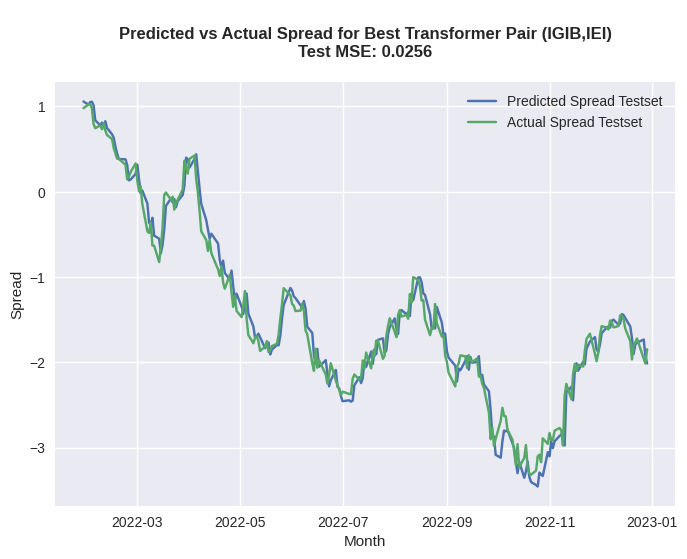

In [23]:
title = f"""
Predicted vs Actual Spread for Best Transformer Pair (IGIB,IEI)
Test MSE: {output_transformer['test_mse']:.4f}
"""

plt.title(title, fontweight='bold')
plt.plot(output_transformer['forecast_test_shortened_series'], label="Predicted Spread Testset")
plt.plot(output_transformer['gt_test_shortened_series'], label="Actual Spread Testset")
plt.xlabel("Month")
plt.ylabel("Spread")
plt.legend()
plt.show()

## Time-MoE

In [19]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = {'learning_rate': 2.0475604252491958e-05, 'min_learning_rate': 2.6086424722448012e-06, 'warmup_ratio': 0.048810916053081604, 'weight_decay': 0.24532990507861047, 'batch_size': 128, 'adam_beta1': 0.8845073518509828, 'adam_beta2': 0.9823969626258993, 'adam_epsilon': 2.736776387774778e-10}

### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2022
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

wanted_pair = pairs_data_filtered[2][0]
ticker_a, ticker_b = wanted_pair[0], wanted_pair[1]
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###

### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2024
pair_tup_str_current = f"({ticker_a},{ticker_b})"
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
output_timemoe = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
# print(output_timemoe
yoy_str = f"{output_timemoe['yoy_mean'] * 100:.2f}% +- {output_timemoe['yoy_std'] * 100:.2f}%"
returns_score = return_score(output_timemoe['yoy_mean'], gt_yoy)

Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-17 10:41:49,080 - log_util.py[pid:703;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/891 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/227M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

100%|██████████| 1/1 [00:00<00:00, 14122.24it/s]


Step,Training Loss
1,0.025900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


configuration_time_moe.py:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Maple728/TimeMoE-50M:
- configuration_time_moe.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



Validation MSE: 0.08830547534680415
Test MSE: 0.018602728334041016
YOY Returns: 0.87%
YOY Std: +- 0.09%
GT Yoy: 0.88%
Plot filepath parent dir: data/results
pair_tup_str: (IGSB,BND)
  


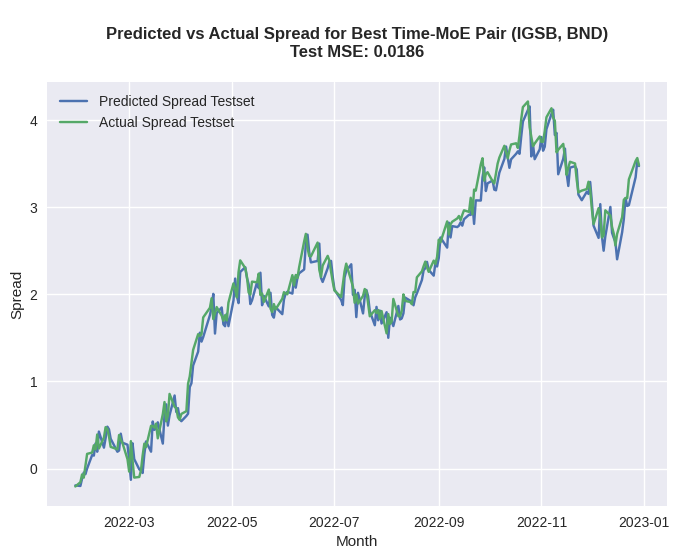

In [24]:
title = f"""
Predicted vs Actual Spread for Best Time-MoE Pair (IGSB, BND)
Test MSE: {output_timemoe['test_mse']:.4f}
"""

plt.title(title, fontweight='bold')
plt.plot(output_timemoe['forecast_test_shortened_series'], label="Predicted Spread Testset")
plt.plot(output_timemoe['gt_test_shortened_series'], label="Actual Spread Testset")
plt.xlabel("Month")
plt.ylabel("Spread")
plt.legend()
plt.show()

In [ ]:
for i, output in enumerate(all_outputs_timemoe_2022):
    gt_test_series, forecast_test_series = output['gt_test_shortened_series'], output['forecast_test_shortened_series']
    plot_comparison(gt_test_series, forecast_test_series, gt_test_series.index, verbose=True, filename_base=f"all_outputs_timemoe_2022_{i}")

In [ ]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = {'learning_rate': 2.0475604252491958e-05, 'min_learning_rate': 2.6086424722448012e-06, 'warmup_ratio': 0.048810916053081604, 'weight_decay': 0.24532990507861047, 'batch_size': 128, 'adam_beta1': 0.8845073518509828, 'adam_beta2': 0.9823969626258993, 'adam_epsilon': 2.736776387774778e-10}


results_all_years = {}
outputs_all_years = {}
for end_year in [2020, 2021, 2022, 2023, 2024]:
  ### Year-specific data ###
  startDateStr = '2008-01-01'
  endDateStr = f'{end_year}-12-31'
  startDateStrTest = f'{end_year}-01-01'
  endDateStrTest = f'{end_year}-12-31'
  train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

  instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
  data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
  data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

  pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  if pairs_data_filtered is None:
    scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
    pairs_data = {key:value[1]  for (key, value) in pairs.items()}
    pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
    pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
    save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  ### Year-specific data ###

  ### OPTIONAL: define worfklow here for debugging ###
  ### OPTIONAL: define worfklow here for debugging ###

  # Gather results for 2024
  results_timemoe_current_year = []
  all_outputs_timemoe_current_year = []
  num_results = min(len(pairs_data_filtered), 10)
  for i in tqdm(range(num_results), desc = "Gathering [...]"):
      ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
      pair_tup_str_current = f"({ticker_a},{ticker_b})"
      pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
      output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
      gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
      output_model = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
      # print(output_model
      yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
      returns_score = return_score(output_model['yoy_mean'], gt_yoy)
      cointegration_score = pairs_data_filtered[i][1]
      results_timemoe_current_year.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
      all_outputs_timemoe_current_year.append(output_model)
  results_all_years[end_year] = results_timemoe_current_year
  outputs_all_years[end_year] = all_outputs_timemoe_current_year


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:52:22,409 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2285.72it/s]


Step,Training Loss
1,0.011000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.028731317622682634
Test MSE: 0.029232571676024707
YOY Returns: -47.57%
YOY Std: +- 69.90%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,SMH)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:52:28,764 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2153.13it/s]


Step,Training Loss
1,0.011000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.055486505040859474
Test MSE: 0.02699584730796495
YOY Returns: -31.11%
YOY Std: +- 59.98%
GT Yoy: 33.16%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,ONEQ)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:52:35,780 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4946.11it/s]


Step,Training Loss
1,0.017600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.039533963248355564
Test MSE: 0.04418646772281635
YOY Returns: -59.32%
YOY Std: +- 55.14%
GT Yoy: 14.67%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,PHO)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:52:42,106 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4156.89it/s]


Step,Training Loss
1,0.011300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.03924861595830838
Test MSE: 0.02771135571361499
YOY Returns: -26.66%
YOY Std: +- 63.59%
GT Yoy: 43.99%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,PDP)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:52:49,263 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1651.30it/s]


Step,Training Loss
1,0.021400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08853497749354756
Test MSE: 0.14000575473921498
YOY Returns: 0.04%
YOY Std: +- 0.02%
GT Yoy: 0.10%
Plot filepath parent dir: data/results
pair_tup_str: (DVY,PEY)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:52:55,595 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3302.60it/s]


Step,Training Loss
1,0.039600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.12619857677832114
Test MSE: 0.22588270094159577
YOY Returns: 0.41%
YOY Std: +- 0.15%
GT Yoy: 0.71%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:53:02,215 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4888.47it/s]


Step,Training Loss
1,0.031400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.01812939600433806
Test MSE: 0.2989169103877188
YOY Returns: 0.06%
YOY Std: +- 0.12%
GT Yoy: -0.36%
Plot filepath parent dir: data/results
pair_tup_str: (IGSB,BND)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:53:08,534 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3184.74it/s]


Step,Training Loss
1,0.022700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.293214297892158
Test MSE: 0.04270744196307555
YOY Returns: 0.13%
YOY Std: +- 0.23%
GT Yoy: 0.41%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SHV)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:53:15,034 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3826.92it/s]


Step,Training Loss
1,0.014700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.2241578474434321
Test MSE: 0.0838085686715567
YOY Returns: 0.25%
YOY Std: +- 0.10%
GT Yoy: 0.31%
Plot filepath parent dir: data/results
pair_tup_str: (PRFZ,SCZ)
  
Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-16 18:53:21,326 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2837.82it/s]


Step,Training Loss
1,0.023600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08387993737317927
Test MSE: 0.04806774098954818
YOY Returns: 0.81%
YOY Std: +- 0.45%
GT Yoy: 0.53%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:53:27,953 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3554.49it/s]


Step,Training Loss
1,0.040300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.22251734012282573
Test MSE: 0.05745849903738038
YOY Returns: 0.24%
YOY Std: +- 0.08%
GT Yoy: 0.35%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:53:34,452 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1795.51it/s]


Step,Training Loss
1,0.025300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.05222501066475606
Test MSE: 0.08541073977533668
YOY Returns: -0.15%
YOY Std: +- 0.03%
GT Yoy: -0.03%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:53:40,840 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1449.81it/s]


Step,Training Loss
1,0.024000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.04569871975828641
Test MSE: 0.07188018277188213
YOY Returns: 0.26%
YOY Std: +- 0.08%
GT Yoy: 0.32%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SHV)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:53:47,392 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2404.99it/s]


Step,Training Loss
1,0.032600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.30943457267927654
Test MSE: 0.09010725663489454
YOY Returns: 0.12%
YOY Std: +- 0.05%
GT Yoy: 0.19%
Plot filepath parent dir: data/results
pair_tup_str: (IGSB,BND)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:53:54,894 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1823.61it/s]


Step,Training Loss
1,0.013200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.02421824103894081
Test MSE: 0.0793948808812714
YOY Returns: -1.31%
YOY Std: +- 51.50%
GT Yoy: 23.38%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SOXX)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:01,803 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2457.12it/s]


Step,Training Loss
1,0.013400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.022596390277692252
Test MSE: 0.08343443904123622
YOY Returns: -44.97%
YOY Std: +- 59.89%
GT Yoy: 19.67%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SMH)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:07,953 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5242.88it/s]


Step,Training Loss
1,0.015600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.03689494579999832
Test MSE: 0.03839222958482945
YOY Returns: 9.21%
YOY Std: +- 2.02%
GT Yoy: 12.06%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,PHO)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:15,106 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1914.33it/s]


Step,Training Loss
1,0.013100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.020451985690500735
Test MSE: 0.09252138149953196
YOY Returns: -91.43%
YOY Std: +- 32.19%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,PDP)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:21,401 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1716.87it/s]


Step,Training Loss
1,0.013800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.04082144594764711
Test MSE: 0.027033602262129794
YOY Returns: 9.89%
YOY Std: +- 2.83%
GT Yoy: 12.47%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,FTCS)
  
Split sizes — train: 3023, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:27,946 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4728.64it/s]


Step,Training Loss
1,0.025000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.05010854929608761
Test MSE: 0.09891784508639302
YOY Returns: -10.79%
YOY Std: +- 31.19%
GT Yoy: -0.11%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,USIG)
  


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:34,455 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3858.61it/s]


Step,Training Loss
1,0.031800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.06828862424413336
Test MSE: 0.050117406351387325
YOY Returns: 0.54%
YOY Std: +- 0.12%
GT Yoy: 0.61%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:40,939 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3572.66it/s]


Step,Training Loss
1,0.020900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.09025289187796083
Test MSE: 0.045733607630623466
YOY Returns: 0.33%
YOY Std: +- 0.13%
GT Yoy: 0.43%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:47,438 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3724.96it/s]


Step,Training Loss
1,0.025900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08830547534680415
Test MSE: 0.018602728334041016
YOY Returns: 0.87%
YOY Std: +- 0.09%
GT Yoy: 0.88%
Plot filepath parent dir: data/results
pair_tup_str: (IGSB,BND)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:54:54,009 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5645.09it/s]


Step,Training Loss
1,0.033300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.05552206316060101
Test MSE: 0.02754410127832919
YOY Returns: 0.89%
YOY Std: +- 0.30%
GT Yoy: 1.30%
Plot filepath parent dir: data/results
pair_tup_str: (USIG,IEI)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:00,536 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4092.00it/s]


Step,Training Loss
1,0.013500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.09323053764187446
Test MSE: 0.20267457835229977
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,DVY)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:07,008 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1733.90it/s]


Step,Training Loss
1,0.022400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.03012363370569058
Test MSE: 0.11510141773057263
YOY Returns: 0.07%
YOY Std: +- 0.09%
GT Yoy: 0.27%
Plot filepath parent dir: data/results
pair_tup_str: (DVY,PEY)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:13,891 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2779.53it/s]


Step,Training Loss
1,0.026800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.06956956762172113
Test MSE: 0.024434962520750107
YOY Returns: 0.83%
YOY Std: +- 0.34%
GT Yoy: 1.15%
Plot filepath parent dir: data/results
pair_tup_str: (IGIB,IEI)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:20,407 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4911.36it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.06591851222600222
Test MSE: 0.1711723673348115
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SOXX)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:27,532 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2423.05it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.06930951242712112
Test MSE: 0.19463648239859863
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SMH)
  
Split sizes — train: 3274, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:34,010 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5412.01it/s]


Step,Training Loss
1,0.013200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.030538409866746347
Test MSE: 0.05407622373936892
YOY Returns: -61.78%
YOY Std: +- 52.34%
GT Yoy: 3.70%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,PHO)
  


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:41,369 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3901.68it/s]


Step,Training Loss
1,0.033100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.051087489225083625
Test MSE: 0.09097674864901062
YOY Returns: -0.02%
YOY Std: +- 0.02%
GT Yoy: -0.06%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:47,851 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2131.25it/s]


Step,Training Loss
1,0.021800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.04384337669338304
Test MSE: 0.08899245473573411
YOY Returns: 0.53%
YOY Std: +- 0.17%
GT Yoy: 0.65%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:55:54,319 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 6626.07it/s]


Step,Training Loss
1,0.012900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.20807959139212667
Test MSE: 0.055883216506390276
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,DVY)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:00,768 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5035.18it/s]


Step,Training Loss
1,0.026600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.02433241067347859
Test MSE: 0.06727071023273933
YOY Returns: 0.27%
YOY Std: +- 0.19%
GT Yoy: 0.50%
Plot filepath parent dir: data/results
pair_tup_str: (IGIB,IEI)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:07,271 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4173.44it/s]


Step,Training Loss
1,0.023000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.11565727872765338
Test MSE: 0.053657277040690766
YOY Returns: 0.12%
YOY Std: +- 0.03%
GT Yoy: 0.15%
Plot filepath parent dir: data/results
pair_tup_str: (DVY,PEY)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:14,107 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2796.20it/s]


Step,Training Loss
1,0.034400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.02767914558707304
Test MSE: 0.08134467028652545
YOY Returns: 0.38%
YOY Std: +- 0.24%
GT Yoy: 0.61%
Plot filepath parent dir: data/results
pair_tup_str: (USIG,IEI)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:20,624 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2651.27it/s]


Step,Training Loss
1,0.019900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.033741189891579274
Test MSE: 0.1504577155707437
YOY Returns: 0.46%
YOY Std: +- 0.14%
GT Yoy: 0.25%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,BND)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:27,408 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5165.40it/s]


Step,Training Loss
1,0.011400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.2580275040427529
Test MSE: 0.023902816573746
YOY Returns: -8.15%
YOY Std: +- 48.13%
GT Yoy: 16.05%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SMH)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:33,840 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3778.65it/s]


Step,Training Loss
1,0.020300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.03106166381703263
Test MSE: 0.1868458461410914
YOY Returns: 0.25%
YOY Std: +- 0.10%
GT Yoy: -0.27%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,MBB)
  
Split sizes — train: 3524, dev: 250, test: 252
Using device: cuda
2025-06-16 18:56:40,800 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4634.59it/s]


Step,Training Loss
1,0.011400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.22887170278987234
Test MSE: 0.03219650993311686
YOY Returns: -58.97%
YOY Std: +- 55.89%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SOXX)
  


Gathering [...]:   0%|          | 0/10 [00:00<?, ?it/s]

Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:56:47,419 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5607.36it/s]


Step,Training Loss
1,0.032700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.09239432786604368
Test MSE: 0.0936405969555448
YOY Returns: 0.08%
YOY Std: +- 0.02%
GT Yoy: 0.10%
Plot filepath parent dir: data/results
pair_tup_str: (PFF,EMB)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:56:54,634 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2884.67it/s]


Step,Training Loss
1,0.020600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.184889318564359
Test MSE: 0.09235876728035444
YOY Returns: -42.19%
YOY Std: +- 51.16%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,MBB)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:01,092 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2781.37it/s]


Step,Training Loss
1,0.022700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08863857148718646
Test MSE: 0.07025281824257884
YOY Returns: 0.44%
YOY Std: +- 0.07%
GT Yoy: 0.39%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:07,655 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1810.23it/s]


Step,Training Loss
1,0.025800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.06872991119045643
Test MSE: 0.08798726234386924
YOY Returns: 0.02%
YOY Std: +- 0.01%
GT Yoy: 0.05%
Plot filepath parent dir: data/results
pair_tup_str: (IGIB,IEI)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:14,180 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 5809.29it/s]


Step,Training Loss
1,0.012600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.05464331692859922
Test MSE: 0.1653925733205924
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,DVY)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:20,740 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1423.73it/s]


Step,Training Loss
1,0.032400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.08327506033189216
Test MSE: 0.1884530334746784
YOY Returns: -0.21%
YOY Std: +- 0.05%
GT Yoy: -0.25%
Plot filepath parent dir: data/results
pair_tup_str: (USIG,IEI)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:27,263 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2690.38it/s]


Step,Training Loss
1,0.020000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.14915839348281335
Test MSE: 0.09421923041836613
YOY Returns: -52.57%
YOY Std: +- 52.18%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,BND)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:33,786 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3894.43it/s]


Step,Training Loss
1,0.011800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.020009269039528963
Test MSE: 0.14566013105789075
YOY Returns: -21.83%
YOY Std: +- 54.49%
GT Yoy: 26.74%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SMH)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:40,453 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4588.95it/s]


Step,Training Loss
1,0.011500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.028958209209513305
Test MSE: 0.16737905593339888
YOY Returns: -7.09%
YOY Std: +- 32.49%
GT Yoy: 11.34%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,SOXX)
  
Split sizes — train: 3774, dev: 251, test: 252
Using device: cuda
2025-06-16 18:57:46,988 - log_util.py[pid:2109;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1696.04it/s]


Step,Training Loss
1,0.015600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.030388462180279508
Test MSE: 0.03280763865466177
YOY Returns: -100.00%
YOY Std: +- 0.00%
GT Yoy: -100.00%
Plot filepath parent dir: data/results
pair_tup_str: (IGF,PPH)
  


In [ ]:
for year, result_current in results_all_years.items():
  print(year)
  print(results_to_latex(result_current))

2020
\begin{table}[h]
\centering
\small
\resizebox{\textwidth}{!}{
\begin{tabular}{lcccccc}
\toprule
Pair & Cointegration Score & val MSE & test MSE & YoY Returns (std) & \makecell{Theoretical Return\\Under Perfect\\Information} & Return Score \\
\midrule
1. (SHV,SMH) & $2.46\times 10^{-4}$ & 0.02873 & 0.02923 & $-47.57\% \pm 69.90\%$ & TLOE* & nan \\
2. (SHV,ONEQ) & $4.04\times 10^{-4}$ & 0.05549 & 0.02700 & $-31.11\% \pm 59.98\%$ & 33.16\% & 0.52 \\
3. (SHV,PHO) & $4.13\times 10^{-4}$ & 0.03953 & 0.04419 & $-59.32\% \pm 55.14\%$ & 14.67\% & 0.35 \\
4. (SHV,PDP) & $9.15\times 10^{-4}$ & 0.03925 & 0.02771 & $-26.66\% \pm 63.59\%$ & 43.99\% & 0.51 \\
5. (DVY,PEY) & $1.41\times 10^{-3}$ & 0.08853 & 0.14001 & $0.04\% \pm 0.02\%$ & 0.10\% & 1.00 \\
6. (PFF,EMB) & $1.45\times 10^{-3}$ & 0.12620 & 0.22588 & $0.41\% \pm 0.15\%$ & 0.71\% & 1.00 \\
7. (IGSB,BND) & $1.56\times 10^{-3}$ & 0.01813 & 0.29892 & $0.06\% \pm 0.12\%$ & -0.36\% & 1.00 \\
8. (IFGL,SHV) & $3.95\times 10^{-3}$ & 0.29321 & 